# Learning To Cache With No Regrets [(Paper)](https://arxiv.org/pdf/1904.09849.pdf) 

We explore the results from the paper. 

In [1]:
import numpy as np
from tqdm import tqdm

N = 1000
C = 100
w_n = 1
eps = 1e-32
T = 2 * 10 ** 4

def custom_normal(T:int, N:int,
                  mean_start: float = 250,
                  mean_end: float = 450):
    """
    """
    out = []
    mean = mean_start
    for idx in range(T):
        mean += ((mean_end - mean_start) / T)
        out.append(
            np.random.normal(mean, N // 16, size=1).astype(int)[0]
        )

    return np.abs(np.array(out))

def custom_poisson(T:int,
                   N: int,
                   lam_start: float = 0,
                   lam_end: float = 750,
                   epochs: int = 2):
    """Generate a custom non-stationary
    poisson shot
    """
    out= []
    lam = lam_start
    for idx in range(T):
        if idx % epochs == 0:
            lam = lam_start + idx * ((lam_end - lam_start) / T)
        out.append(np.random.poisson(lam=lam,size=1)[0])

    return np.array(out)

def custom_zipf(N: int, a: float, T: int):
    """Generate a custom zipf"""
    ns = np.arange(N)
    ps = (1 / (ns+1) ** a) 
    ps = ps / sum(ps)
    return np.random.choice(ns, size=T, p=ps)

REQUESTS = custom_zipf(N, 0.64, T)

print("MAX:", max(REQUESTS)) 

MAX: 999


In [2]:
import time
loop1, loop2 = 0,0

def oga_epoch(Z: np.ndarray):
    """
    """

    zdx = np.argsort(Z, kind="heapsort")[::-1]
    sorted_z = Z[zdx]
    y = np.zeros(N)
    M1 = set()
    M2 = set(range(N))
    M3 = set()
    
    while True:

        if not M2:
            break

        rho = 2 * (len(M1) - C + sorted_z[list(M2)].sum()) / len(M2)

        y[list(M1)] = 1
        y[list(M2)] = sorted_z[list(M2)] - rho / 2
        y[list(M3)] = 0

        S = {n for n in M2 if y[n] < 0}
        M2.difference_update(S)
        M3.update(S)

        if not S:
            break
        
        
    if y[0] > 1:
        M1 = {0}
        M2 = set(range(1,N))
        M3 = set()
        while True:

            if not M2:
                break

            rho = 2 * (len(M1) - C + sorted_z[list(M2)].sum()) / len(M2)

            y[list(M1)] = 1
            y[list(M2)] = sorted_z[list(M2)] - rho / 2
            y[list(M3)] = 0

            S = {n for n in M2 if y[n] < 0}
            M2.difference_update(S)
            M3.update(S)

            if not S:
                break
    og_order = np.zeros(N)
    for i, val in zip(zdx, y):
        og_order[i] = val

    return og_order


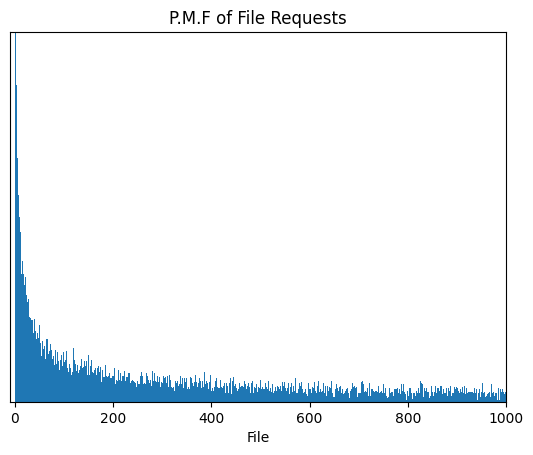

In [14]:
import matplotlib.pyplot as plt
ax = plt.subplot()

plt.hist(REQUESTS, bins=N)
plt.xlim([-10, 1000])
plt.ylim([0, 300])
plt.xlabel("File")
plt.ylabel("Request Probability")
plt.title("P.M.F of File Requests")
ax.yaxis.set_visible(False)

In [4]:
conv_rates = {}

In [5]:


Z = np.zeros(N)
y = np.zeros(N)
M1, M2, M3 = set(), set(), set()

print("OGA Implementation")
ys , hits = [] , []
rolling_avg = {"oga":[], "lru":[], "lfu":[], "static":[]}
eta = 0.1
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
for idx, req in pbar:

    hits.append(y[req - 1])
    y[req - 1] += eta * w_n * y[req - 1]
    ys.append(y)
    hits = hits[-1000:]
    rolling_avg["oga"].append(sum(hits) / (len(hits) + 1))
    y = oga_epoch(y)
    pbar.set_description(f"Loop1: {loop1} | Loop2: {loop2} | Avg Hits: {sum(hits) / (len(hits) + 1)} | sigma y: {sum(y)}")

conv_rates[eta] = rolling_avg["oga"][:]


OGA Implementation


Loop1: 0 | Loop2: 0 | Avg Hits: 0.08992354078470428 | sigma y: 99.9999999999988:   0%|          | 0/20000 [00:00<?, ?it/s]  

Loop1: 0 | Loop2: 0 | Avg Hits: 0.3885930091103186 | sigma y: 100.0: 100%|██████████| 20000/20000 [00:29<00:00, 669.56it/s]              


Text(0.5, 1.0, 'OGA Decision Vector / Time')

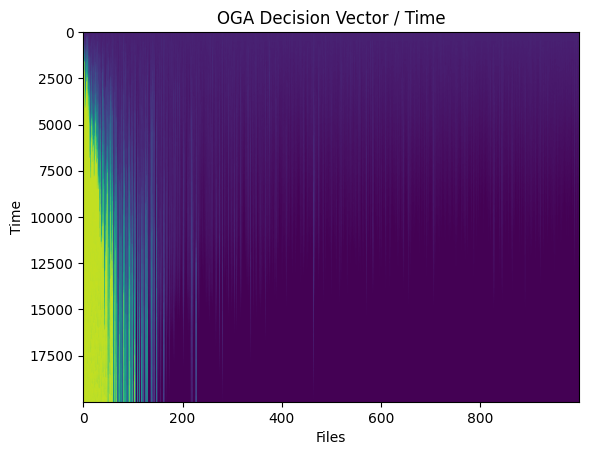

In [6]:
ys = np.array(ys)
plt.imshow(ys, aspect='auto', origin='upper', cmap='viridis')
plt.xlabel("Files")
plt.ylabel("Time")
plt.title("OGA Decision Vector / Time")

In [7]:
lru_cache = []
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []
ys = []

for idx, req in pbar:
    if (req - 1) in lru_cache:
        hits.append(1)
        lru_cache = list(filter(lambda item: item != req - 1, lru_cache))
        lru_cache.append(req - 1)
    else:
        hits.append(0)
        lru_cache.append(req - 1)

    y = np.zeros(N)
    y[lru_cache] = 1.
    ys.append(y)
    
    hits = hits[-1000:]
    rolling_avg["lru"].append(sum(hits) / (len(hits)+1))
    lru_cache = lru_cache[-C:]

    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)} | {len(lru_cache)}")



Avg Hits: 0.24875124875124874 | 100: 100%|██████████| 20000/20000 [00:11<00:00, 1786.81it/s]


Text(0.5, 1.0, 'LRU Decision Vector / Time')

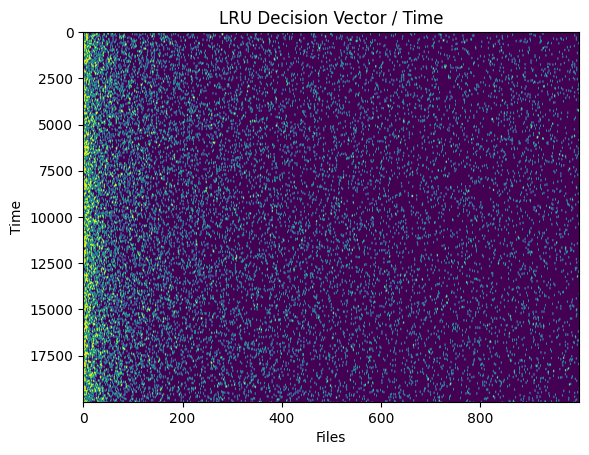

In [8]:
ys = np.array(ys)

plt.imshow(ys, aspect='auto', origin='upper', cmap='viridis')
plt.xlabel("Files")
plt.ylabel("Time")
plt.title("LRU Decision Vector / Time")

In [9]:
#LFU
freqs = np.zeros(N)
pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []
ys = []

for idx, req in pbar:

    if req-1 in np.argsort(freqs)[-C:]:
        hits.append(1)
    else:
        hits.append(0)

    y = np.zeros(N)
    y[np.argsort(freqs)[-C:]] = 1.
    ys.append(y)

    hits = hits[-1000:]
    rolling_avg["lfu"].append(sum(hits) / (len(hits)+1))
    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)}")
    freqs[req - 1] += 1




Avg Hits: 0.3706293706293706: 100%|██████████| 20000/20000 [00:13<00:00, 1522.86it/s] 


Text(0.5, 1.0, 'LFU Decision Vector / Time')

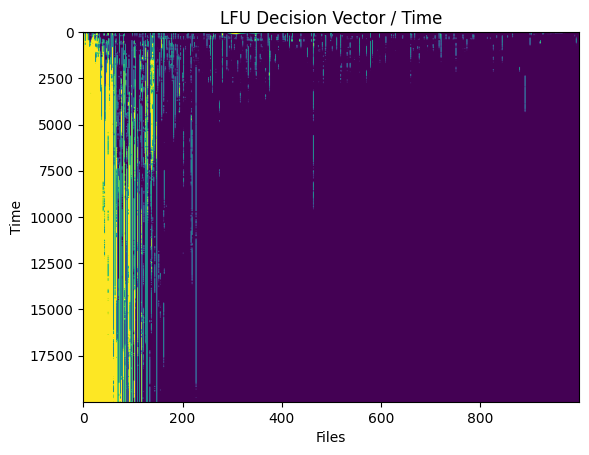

In [10]:
ys = np.array(ys)

plt.imshow(ys, aspect='auto', origin='upper', cmap='viridis')
plt.xlabel("Files")
plt.ylabel("Time")
plt.title("LFU Decision Vector / Time")

In [11]:
#static policy
_ , counts = np.unique(REQUESTS, return_counts=True)
static_cache = np.argsort(counts)[-C:]

pbar = tqdm(enumerate(REQUESTS), total=len(REQUESTS))
hits = []

for idx, req in pbar:

    if req-1 in static_cache:
        hits.append(1)
    else:
        hits.append(0)

    hits = hits[-1000:]
    rolling_avg["static"].append(sum(hits) / (len(hits)+1))
    pbar.set_description(f"Avg Hits: {sum(hits) / (len(hits) + 1)}")



Avg Hits: 0.3696303696303696: 100%|██████████| 20000/20000 [00:10<00:00, 1847.65it/s] 


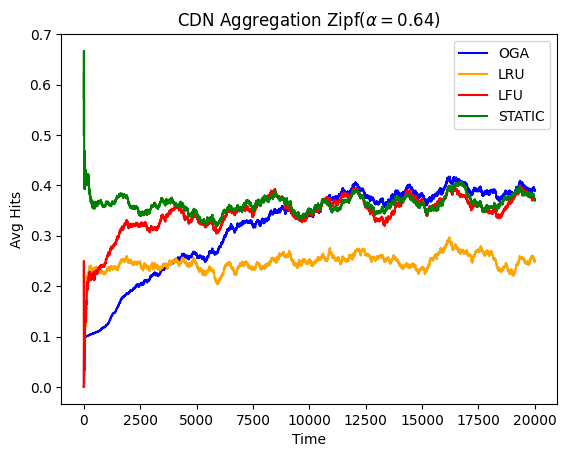

In [13]:
highlight = {
    "lru":"orange",
    "oga":"blue",
    "lfu":"red",
    "static":"green"
}
for name, data in rolling_avg.items():
    if name not in highlight:
        plt.plot(data, label=name.upper(), color="grey")

for name, data in rolling_avg.items():
    if name in highlight:
        plt.plot(data, label=name.upper(),color=highlight[name])

plt.title("CDN Aggregation Zipf($\\alpha = 0.64$)")
plt.ylabel("Avg Hits")
plt.xlabel("Time")
plt.legend()